# Isolation Forest on PCA space

Unsupervised anomaly detection tuned on the PCA outputs.

## Imports and plotting defaults

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.model_selection import train_test_split, ParameterGrid

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

DATA_DIR = Path('../data')
RANDOM_STATE = 42

## Load PCA datasets
Pull the saved PCA projections. Run the PCA notebook first if these files are missing.

In [2]:

train_path = DATA_DIR / 'PCA-nsl_kdd_train.csv'
test_path = DATA_DIR / 'PCA-nsl_kdd_test.csv'
if not train_path.exists() or not test_path.exists():
    raise FileNotFoundError('Run the PCA notebook to create the PCA-nsl_kdd CSV files first.')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
label_col = 'attack_flag' if 'attack_flag' in train_df.columns else 'attack_type'
feature_cols = [col for col in train_df.columns if col != label_col]

X_train_pca = train_df[feature_cols].to_numpy()
X_test_pca = test_df[feature_cols].to_numpy()
if label_col == 'attack_flag':
    y_train = train_df[label_col].astype(int).to_numpy()
    y_test = test_df[label_col].astype(int).to_numpy()
else:
    y_train = (train_df[label_col] != 'normal').astype(int).to_numpy()
    y_test = (test_df[label_col] != 'normal').astype(int).to_numpy()

print(f'PCA feature shape (train/test): {X_train_pca.shape} / {X_test_pca.shape}')
print(f'Attack rate train/test: {y_train.mean():.2%} / {y_test.mean():.2%}')


PCA feature shape (train/test): (125973, 18) / (22544, 18)
Attack rate train/test: 46.54% / 56.92%


## Isolation Forest validation split
Hold out part of the training data to tune hyperparameters.

In [3]:
X_if_train, X_if_val, y_if_train, y_if_val = train_test_split(
    X_train_pca,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=RANDOM_STATE
)

print(f'Isolation Forest train size: {X_if_train.shape[0]} | validation size: {X_if_val.shape[0]}')

Isolation Forest train size: 100778 | validation size: 25195


## Hyperparameter sweep

In [4]:
attack_rate = y_train.mean()
contamination_candidates = [
    max(0.01, attack_rate * 0.6),
    max(0.01, attack_rate * 0.8),
    max(0.01, attack_rate),
    max(0.01, min(0.5, attack_rate * 1.2))
]
contamination_values = sorted({round(min(0.5, c), 4) for c in contamination_candidates})

param_grid = {
    'n_estimators': [256, 512],
    'max_samples': [0.6, 0.9],
    'contamination': contamination_values
}

search_results = []
for params in ParameterGrid(param_grid):
    model = IsolationForest(random_state=RANDOM_STATE, n_jobs=-1, **params)
    model.fit(X_if_train)
    val_scores = -model.decision_function(X_if_val)
    val_preds = (model.predict(X_if_val) == -1).astype(int)

    search_results.append({
        'n_estimators': params['n_estimators'],
        'max_samples': params['max_samples'],
        'contamination': round(params['contamination'], 4),
        'precision': precision_score(y_if_val, val_preds),
        'recall': recall_score(y_if_val, val_preds),
        'f1': f1_score(y_if_val, val_preds),
        'roc_auc': roc_auc_score(y_if_val, val_scores)
    })

results_df = pd.DataFrame(search_results).sort_values('f1', ascending=False).reset_index(drop=True)
results_df

,n_estimators,max_samples,contamination,precision,recall,f1,roc_auc
0,512,0.9,0.5000,0.461326,0.497953,0.478940,0.571870
1,512,0.6,0.5000,0.461089,0.497697,0.478694,0.573524
2,256,0.9,0.5000,0.457981,0.494030,0.475323,0.569126
3,256,0.6,0.5000,0.449365,0.485502,0.466735,0.558626
4,512,0.6,0.4654,0.465601,0.466911,0.466255,0.573524
5,512,0.9,0.4654,0.463071,0.465717,0.464390,0.571870
6,256,0.9,0.4654,0.461225,0.463585,0.462402,0.569126
7,256,0.6,0.4654,0.458961,0.460174,0.459566,0.558626
8,256,0.9,0.3723,0.504515,0.404997,0.449312,0.569126
9,256,0.6,0.3723,0.499629,0.401671,0.445327,0.558626


## Train final Isolation Forest & evaluate

In [5]:
best_row = results_df.iloc[0]
best_params = {
    'n_estimators': int(best_row['n_estimators']),
    'max_samples': float(best_row['max_samples']),
    'contamination': float(best_row['contamination'])
}

print(f'Best hyperparameters: {best_params}')

best_model = IsolationForest(random_state=RANDOM_STATE, n_jobs=-1, **best_params)
best_model.fit(X_train_pca)

def evaluate_split(name, X, y):
    scores = -best_model.decision_function(X)
    preds = (best_model.predict(X) == -1).astype(int)
    print(f'[{name}] attack share: {y.mean():.2%}')
    print(classification_report(y, preds, target_names=['Normal', 'Attack']))
    print('ROC-AUC:', roc_auc_score(y, scores))
    print('Confusion matrix:', confusion_matrix(y, preds))
    print('-' * 60)

evaluate_split('Train', X_train_pca, y_train)
evaluate_split('Test', X_test_pca, y_test)

Best hyperparameters: {'n_estimators': 512, 'max_samples': 0.9, 'contamination': 0.5}
[Train] attack share: 46.54%
              precision    recall  f1-score   support

      Normal       0.53      0.49      0.51     67343
      Attack       0.46      0.49      0.47     58630

    accuracy                           0.49    125973
   macro avg       0.49      0.49      0.49    125973
weighted avg       0.49      0.49      0.49    125973

ROC-AUC: 0.5675691716777704
Confusion matrix: [[33191 34152]
 [29796 28834]]
------------------------------------------------------------
[Test] attack share: 56.92%
              precision    recall  f1-score   support

      Normal       0.88      0.62      0.73      9711
      Attack       0.76      0.94      0.84     12833

    accuracy                           0.80     22544
   macro avg       0.82      0.78      0.79     22544
weighted avg       0.82      0.80      0.79     22544

ROC-AUC: 0.8072109532383733
Confusion matrix: [[ 6010  3701]
 [  

## Metric comparison summary
A consolidated table that reports Accuracy, Precision, Recall, F1, and ROC-AUC for the Isolation Forest on the training (before) and test (after) splits, matching the evaluation dimensions requested by the team.


In [6]:
def summarize_split(name, X, y):
    scores = -best_model.decision_function(X)
    preds = (best_model.predict(X) == -1).astype(int)
    return {
        'split': name,
        'accuracy': accuracy_score(y, preds),
        'precision': precision_score(y, preds),
        'recall': recall_score(y, preds),
        'f1': f1_score(y, preds),
        'roc_auc': roc_auc_score(y, scores)
    }

metric_summary = pd.DataFrame([
    summarize_split('Before (train)', X_train_pca, y_train),
    summarize_split('After (test)', X_test_pca, y_test)
]).set_index('split')

print('Isolation Forest metrics by split (higher is better)')
display(metric_summary.round(3))


Isolation Forest metrics by split (higher is better)


,accuracy,precision,recall,f1,roc_auc
split,,,,,
Before (train),0.492,0.458,0.492,0.474,0.568
After (test),0.801,0.765,0.938,0.843,0.807


## Threshold analysis (normal vs attack)

In [7]:

train_scores = -best_model.decision_function(X_train_pca)
test_scores = -best_model.decision_function(X_test_pca)
contamination = best_params['contamination']
threshold = float(np.quantile(train_scores, 1 - contamination))

print(f"--- Threshold Analysis (top {contamination:.2%} of anomaly scores flagged as attack) ---\n")

def describe_split(name, scores, labels):
    labels = labels.to_numpy() if hasattr(labels, 'to_numpy') else labels
    normal_mask = labels == 0
    attack_mask = labels == 1

    normal_above = int((scores[normal_mask] > threshold).sum())
    normal_below = int((scores[normal_mask] <= threshold).sum())
    attack_above = int((scores[attack_mask] > threshold).sum())
    attack_below = int((scores[attack_mask] <= threshold).sum())

    total_normal = normal_mask.sum()
    total_attack = attack_mask.sum()

    print(f"{name} split (threshold = {threshold:.4f}):")
    print(
        f"  Normal traffic  -> Above: {normal_above:,} ({normal_above/total_normal:.1%}), "
        f"Below: {normal_below:,} ({normal_below/total_normal:.1%})"
    )
    print(
        f"  Attack traffic  -> Above: {attack_above:,} ({attack_above/total_attack:.1%}), "
        f"Below: {attack_below:,} ({attack_below/total_attack:.1%})\n"
    )

    summary = pd.DataFrame([
        (name, 'Normal', 'Allowed (normal)', normal_below, normal_below / total_normal),
        (name, 'Normal', 'Blocked (attack)', normal_above, normal_above / total_normal),
        (name, 'Attack', 'Allowed (normal)', attack_below, attack_below / total_attack),
        (name, 'Attack', 'Blocked (attack)', attack_above, attack_above / total_attack),
    ], columns=['split', 'actual', 'decision', 'count', 'share'])
    summary['threshold'] = threshold
    summary['share_pct'] = (summary['share'] * 100).round(1)
    return summary[['split', 'threshold', 'actual', 'decision', 'count', 'share', 'share_pct']]

train_threshold_df = describe_split('Before (train)', train_scores, y_train)
test_threshold_df = describe_split('After (test)', test_scores, y_test)
threshold_summary = pd.concat([train_threshold_df, test_threshold_df], ignore_index=True)
threshold_summary


--- Threshold Analysis (top 50.00% of anomaly scores flagged as attack) ---

Before (train) split (threshold = 0.0000):
  Normal traffic  -> Above: 34,152 (50.7%), Below: 33,191 (49.3%)
  Attack traffic  -> Above: 28,834 (49.2%), Below: 29,796 (50.8%)

After (test) split (threshold = 0.0000):
  Normal traffic  -> Above: 3,701 (38.1%), Below: 6,010 (61.9%)
  Attack traffic  -> Above: 12,041 (93.8%), Below: 792 (6.2%)



,split,threshold,actual,decision,count,share,share_pct
0,Before (train),0.0,Normal,Allowed (normal),33191,0.492865,49.3
1,Before (train),0.0,Normal,Blocked (attack),34152,0.507135,50.7
2,Before (train),0.0,Attack,Allowed (normal),29796,0.508204,50.8
3,Before (train),0.0,Attack,Blocked (attack),28834,0.491796,49.2
4,After (test),0.0,Normal,Allowed (normal),6010,0.618886,61.9
5,After (test),0.0,Normal,Blocked (attack),3701,0.381114,38.1
6,After (test),0.0,Attack,Allowed (normal),792,0.061716,6.2
7,After (test),0.0,Attack,Blocked (attack),12041,0.938284,93.8


## Attack passage rates
Summarizes what percentage (and count) of attack flows are blocked vs allowed before and after deployment, so stakeholders can quote "attacks getting through" directly.


In [8]:
attack_rows = threshold_summary[threshold_summary['actual'] == 'Attack'].copy()
attack_rows['decision'] = attack_rows['decision'].map({
    'Blocked (attack)': 'Blocked (flagged)',
    'Allowed (normal)': 'Allowed through'
})
attack_rows['split'] = attack_rows['split'].str.replace('Train', 'Before (train)').str.replace('Test', 'After (test)')

attack_pct = attack_rows.pivot(index='split', columns='decision', values='share_pct').rename(columns=str.title)
attack_counts = attack_rows.pivot(index='split', columns='decision', values='count')

attack_summary = pd.concat({
    'percent': attack_pct.round(1),
    'count': attack_counts.astype(int)
}, axis=1)

print('Attack flows: percentage and counts above/below threshold')
display(attack_summary)

for split, row in attack_rows.groupby('split'):
    allowed = row[row['decision'] == 'Allowed through']['share_pct'].iloc[0]
    blocked = row[row['decision'] == 'Blocked (flagged)']['share_pct'].iloc[0]
    print(f"{split}: {blocked:.1f}% of attacks flagged, {allowed:.1f}% slip through")


Attack flows: percentage and counts above/below threshold


percent                             count  \
decision       Allowed Through Blocked (Flagged) Allowed through   
split                                                              
After (test)               6.2              93.8             792   
Before (train)            50.8              49.2           29796   

                                  
decision       Blocked (flagged)  
split                             
After (test)               12041  
Before (train)             28834

After (test): 93.8% of attacks flagged, 6.2% slip through
Before (train): 49.2% of attacks flagged, 50.8% slip through


## Threshold visualization
Plot anomaly scores for every record (train/test) sorted by score, and overlay the adaptive threshold derived from the contamination rate.


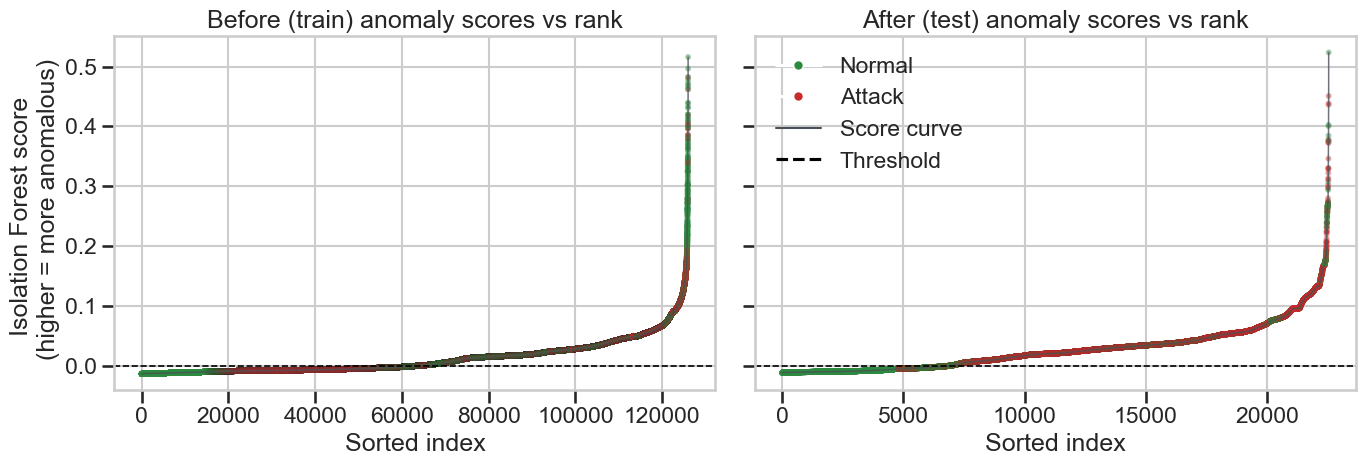

In [9]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

split_payload = [
    ('Before (train)', train_scores, y_train),
    ('After (test)', test_scores, y_test)
]

for ax, (name, scores, labels) in zip(axes, split_payload):
    label_array = labels if isinstance(labels, np.ndarray) else labels.to_numpy()
    order = np.argsort(scores)
    ordered_scores = scores[order]
    ordered_labels = label_array[order]
    colors = np.where(ordered_labels == 1, '#c92a2a', '#2b8a3e')
    x_idx = np.arange(len(ordered_scores))

    ax.scatter(x_idx, ordered_scores, c=colors, s=8, alpha=0.35)
    ax.plot(x_idx, ordered_scores, color='#495057', linewidth=1.1, alpha=0.8)
    ax.axhline(threshold, color='black', linestyle='--', linewidth=1.2)
    ax.set_title(f'{name} anomaly scores vs rank')
    ax.set_xlabel('Sorted index')

axes[0].set_ylabel('Isolation Forest score \n (higher = more anomalous)')

legend_handles = [
    Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='#2b8a3e', markersize=7),
    Line2D([0], [0], marker='o', color='w', label='Attack', markerfacecolor='#c92a2a', markersize=7),
    Line2D([0], [0], color='#495057', linewidth=1.5, label='Score curve'),
    Line2D([0], [0], color='black', linestyle='--', label='Threshold')
]
axes[1].legend(handles=legend_handles, loc='best')

plt.tight_layout()
plt.show()


## Diagnostics & visualization

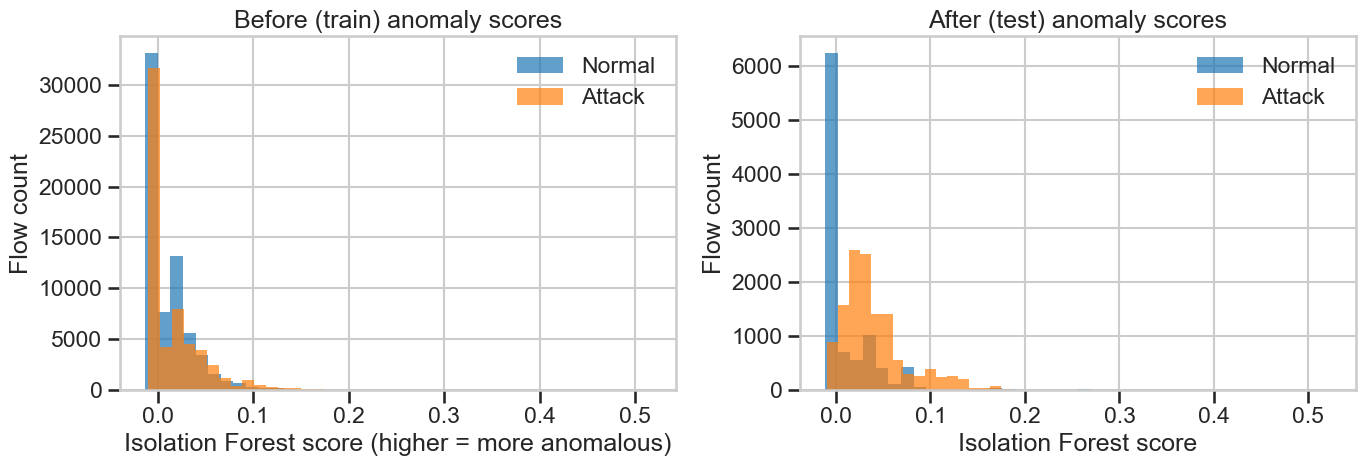

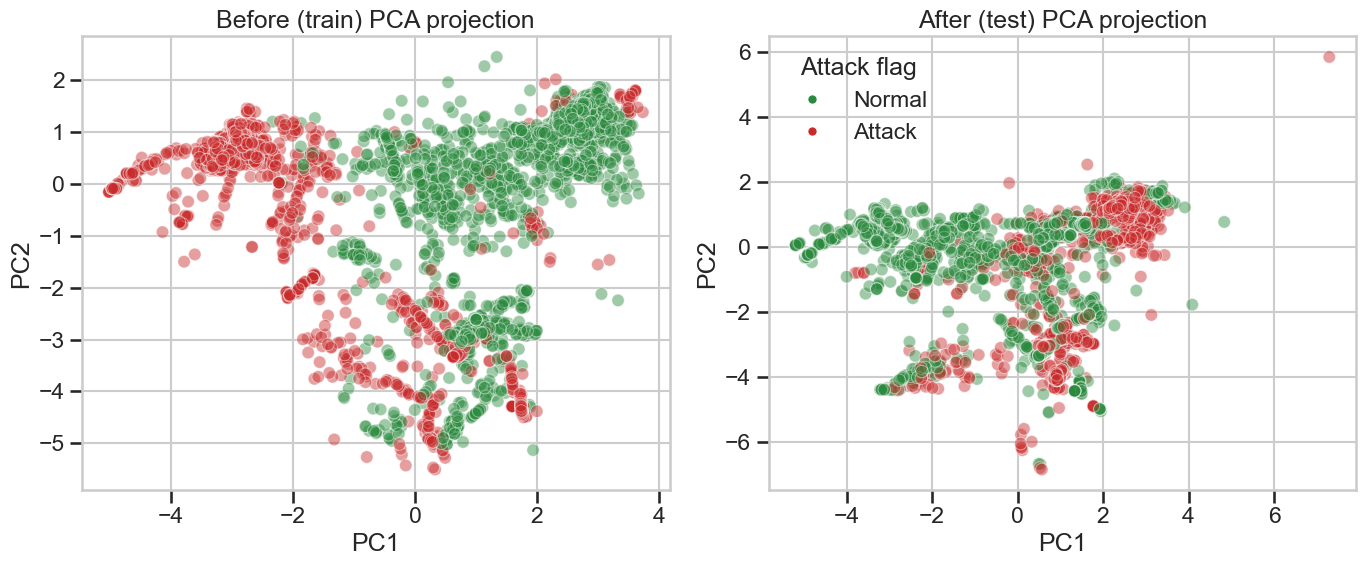

In [10]:
train_scores = -best_model.decision_function(X_train_pca)
test_scores = -best_model.decision_function(X_test_pca)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(train_scores[y_train == 0], bins=40, alpha=0.7, label='Normal')
axes[0].hist(train_scores[y_train == 1], bins=40, alpha=0.7, label='Attack')
axes[0].set_title('Before (train) anomaly scores')
axes[0].set_xlabel('Isolation Forest score (higher = more anomalous)')
axes[0].set_ylabel('Flow count')
axes[0].legend()

axes[1].hist(test_scores[y_test == 0], bins=40, alpha=0.7, label='Normal')
axes[1].hist(test_scores[y_test == 1], bins=40, alpha=0.7, label='Attack')
axes[1].set_title('After (test) anomaly scores')
axes[1].set_xlabel('Isolation Forest score')
axes[1].set_ylabel('Flow count')
axes[1].legend()

plt.tight_layout()
plt.show()

rng = np.random.default_rng(RANDOM_STATE)
scatter_payload = [
    ('Before (train)', X_train_pca, y_train),
    ('After (test)', X_test_pca, y_test)
]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for ax, (name, X, labels) in zip(axes, scatter_payload):
    subset = min(6000, X.shape[0])
    idx = rng.choice(X.shape[0], size=subset, replace=False)
    label_array = labels if isinstance(labels, np.ndarray) else labels.to_numpy()
    scatter_df = pd.DataFrame({
        'pc1': X[idx, 0],
        'pc2': X[idx, 1],
        'label': label_array[idx]
    })
    scatter_df['label_name'] = scatter_df['label'].map({0: 'Normal', 1: 'Attack'})

    sns.scatterplot(
        data=scatter_df,
        x='pc1',
        y='pc2',
        hue='label_name',
        palette=['#2b8a3e', '#c92a2a'],
        alpha=0.45,
        ax=ax,
        legend=False
    )
    ax.set_title(f'{name} PCA projection')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

handles = [
    Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='#2b8a3e', markersize=7),
    Line2D([0], [0], marker='o', color='w', label='Attack', markerfacecolor='#c92a2a', markersize=7)
]
axes[-1].legend(handles=handles, title='Attack flag', loc='best')
plt.tight_layout()
plt.show()


*Figure notes:* The threshold plot overlays (sorted anomaly scores plus dashed cutoff) and the PCA scatter grids (before vs after) translate the numeric metrics into visuals, showing exactly where normals/attacks sit relative to the learned boundary.
